# hand-sign recognizer (Residual Network)
Here we build a convolutional neural-network for recognizing hand-signs, which uses residual networks (or skip connections).

> Inspired by: [Convolutional Neural Networks](https://www.coursera.org/learn/convolutional-neural-networks)

In [1]:
import torch
from torchvision.transforms import Lambda
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn

from collections import OrderedDict
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import math
import util

import sys, os, importlib
sys.path.append(os.path.join("..", "data"))

from loaders import hand_signs
_ = importlib.reload(hand_signs)
_ = importlib.reload(util)

## # loading and pre-processing data

In [2]:
one_hot_transform = Lambda(lambda y: torch.zeros(6, dtype=torch.float)\
    .scatter_(dim=0, index=y, value=1))
train_data = hand_signs.HandSigns(train=True)
norm_transform = train_data.get_norm_transform()
test_data = hand_signs.HandSigns(train=False, transform=norm_transform)
class_labels = train_data.get_class_labels()

print(f"# of training-examples: {len(train_data)}")
print(f"# of test-examples: {len(test_data)}")
# [3] -> (image, label) pair at idx-3, [0] -> image
print(f"image-dimensions: {train_data[3][0].shape}")
print(f"class-labels: {len(class_labels)}")

# of training-examples: 1080
# of test-examples: 120
image-dimensions: torch.Size([3, 64, 64])
class-labels: 6


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## # architecture
Any residual block can be categorized into the following types:
* **Convolutional [ResNet] Block**:
<div style="text-align:center">
    <img src="./img/conv-block.png" />
    <br><b>Fig.1:</b> schema of a Convolutional ResNet-block, that skips over k-layers.
</div>

In the following model, we have $k=3$. Also, given the values for $s, f,$ and $\mathrm{C}_j \forall 1 \le j \le k$, we have the following architecture:

<center>

| Layer | Layer-type | Component   | Properties               | Details        |                               |
|-------|------------|-------------|--------------------------|----------------|-------------------------------|
| 1     | conv       | #-kernels   | $c^{[1]}$                | $\mathrm{C}_1$ | initializer: `glorot_uniform` |
|       |            | kernel-size | $(h^{[1]}_k, w^{[1]}_k)$ | $(1,1)$        |                               |
|       |            | padding     | `<valid>`                |                |                               |
|       |            | stride      | $(h^{[1]}_s, w^{[1]}_s)$ | $(s,s)$        |                               |
|       |            | batch-norm  | momentum, epsilon        | $0.99, 1e-3$   |                               |
|       |            | activation  | `relu`                   |                |                               |
| 2     | conv       | #-kernels   | $c^{[2]}$                | $\mathrm{C}_2$ | initializer: `glorot_uniform` |
|       |            | kernel-size | $(h^{[2]}_k, w^{[2]}_k)$ | $(f,f)$        |                               |
|       |            | padding     | `<same>`                 |                |                               |
|       |            | stride      | $(h^{[2]}_s, w^{[2]}_s)$ | $(1,1)$        |                               |
|       |            | batch-norm  | momentum, epsilon        | $0.99, 1e-3$   |                               |
|       |            | activation  | `relu`                   |                |                               |
| 3     | conv       | #-kernels   | $c^{[3]}$                | $\mathrm{C}_3$ | initializer: `glorot_uniform` |
|       |            | kernel-size | $(h^{[3]}_k, w^{[3]}_k)$ | $(1,1)$        |                               |
|       |            | stride      | $(h^{[3]}_s, w^{[3]}_s)$ | $(1,1)$        |                               |
|       |            | padding     | `<valid>`                |                |                               |
|       |            | batch-norm  | momentum, epsilon        | $0.99, 1e-3$   |                               |
| --    | Add Residue | --          | --                       | --             | --                            |
|       |            | activation  | `relu`                   |                |                               |
| 4-res | conv       | #-kernels   | $c^{[4]}$                | $\mathrm{C}_3$ | initializer: `glorot_uniform` |
|       |            | kernel-size | $(h^{[4]}_k, w^{[4]}_k)$ | $(1,1)$        |                               |
|       |            | stride      | $(h^{[4]}_s, w^{[4]}_s)$ | $(s,s)$        |                               |
|       |            | padding     | `<valid>`                |                |                               |
|       |            | batch-norm  | momentum, epsilon        | $0.99, 1e-3$   |                               |

</center>
<br><br>

* **Identity [ResNet] Block**:
<div style="text-align:center">
    <img src="./img/identity-block.png" />
    <br><b>Fig.2:</b> schema of a Identity ResNet-block, that skips over k-layers.
</div>

In the following model, we have $k=3$. Also, given the values for $f,$ and $\mathrm{C}_j \forall 1 \le j \le k$, we have the following architecture:

<center>

| Layer | Layer-type  | Component   | Properties               | Details        |                               |
|-------|-------------|-------------|--------------------------|----------------|-------------------------------|
| 1     | conv        | #-kernels   | $c^{[1]}$                | $\mathrm{C}_1$ | initializer: `random_normal`  |
|       |             | kernel-size | $(h^{[1]}_k, w^{[1]}_k)$ | $(1,1)$        |                               |
|       |             | padding     | `<valid>`                |                |                               |
|       |             | stride      | $(h^{[1]}_s, w^{[1]}_s)$ | $(1,1)$        |                               |
|       |             | batch-norm  | momentum, epsilon        | $0.99, 1e-3$   |                               |
|       |             | activation  | `relu`                   |                |                               |
| 2     | conv        | #-kernels   | $c^{[2]}$                | $\mathrm{C}_2$ | initializer: `glorot_uniform` |
|       |             | kernel-size | $(h^{[2]}_k, w^{[2]}_k)$ | $(f,f)$        |                               |
|       |             | padding     | `<same>`                 |                |                               |
|       |             | stride      | $(h^{[2]}_s, w^{[2]}_s)$ | $(1,1)$        |                               |
|       |             | batch-norm  | momentum, epsilon        | $0.99, 1e-3$   |                               |
|       |             | activation  | `relu`                   |                |                               |
| 3     | conv        | #-kernels   | $c^{[3]}$                | $\mathrm{C}^3$ | initializer: `glorot_uniform` |
|       |             | kernel-size | $(h^{[3]}_k, w^{[3]}_k)$ | $(1,1)$        |                               |
|       |             | stride      | $(h^{[3]}_s, w^{[3]}_s)$ | $(1,1)$        |                               |
|       |             | padding     | `<valid>`                |                |                               |
|       |             | batch-norm  | momentum, epsilon        | $0.99, 1e-3$   |                               |
| --    | Add Residue | --          | --                       | --             | --                            |
|       |             | activation  | `relu`                   |                |                               |

</center>
<br><br>

* **Overall Architecture**:
We will build a network with 50-layers, with the following schema:

<div style="text-align:center">
    <img src="./img/resnet-50L.png" />
    <br><b>Fig.3:</b> schema of the 50-layer network that we will use.
</div>

<br><br>
Also, note the following about the above architecture:

* **Input**:
<center>

| Layer | Layer-type  | Component      | Properties                           | Details |
|-------|-------------|----------------|--------------------------------------|---------|
| 0     | conv [like] | channels       | $c^{[0]}$                            | 3       |
|       |             | input-size     | $(h^{[0]}_a, w^{[0]}_a)$             | (64,64) |
|       |             | padding        | $(h^{[0]}_p, w^{[0]}_p)$             | (3,3)   |

</center>

* **Stage-1**:
<center>

| Layer | Layer-type  | Component      | Properties                           | Details |
|-------|-------------|----------------|--------------------------------------|---------|
| 1     | conv-2d     | #-kernels      | $c^{[1]}$                            | 64      |
|       |             | kernel-size    | $(h^{[1]}_k, w^{[1]}_k)$             | (7,7)   |
|       |             | conv-stride    | $(h^{[1]}_s, w^{[1]}_s)$             | (2,2)   |
|       |             | batch-norm     | along-channels                       |         |
|       |             | activation     | `relu`                               |         |
|       |             | pooling        | `max`                                |         |
|       |             | pooling-window | $(h^{[1]}_l, w^{[1]}_l)$             | (3,3)   |
|       |             | pooling-stride | $({}^{l}h^{[1]}_s, {}^{l}w^{[1]}_s)$ | (2,2)   |

</center>

* **Stage-2, 3, 4, & 5**:
<center>

| Stage | Block-type | Component      | Details |
|-------|------------|----------------|---------|
| 2     | 'conv'     | $\mathrm{C}_1$ | $64$    |
|       |            | $\mathrm{C}_2$ | $64$    |
|       |            | $\mathrm{C}_3$ | $256$   |
|       |            | $(f, s)$       | $(3,1)$ |
|       | 'idnt'     | $\mathrm{C}_1$ | $64$    |
|       |            | $\mathrm{C}_2$ | $64$    |
|       |            | $\mathrm{C}_3$ | $256$   |
|       |            | $(f,)$         | $(3,)$  |
| 3     | 'conv'     | $\mathrm{C}_1$ | $128$   |
|       |            | $\mathrm{C}_2$ | $128$   |
|       |            | $\mathrm{C}_3$ | $512$   |
|       |            | $(f, s)$       | $(3,2)$ |
|       | 'idnt'     | $\mathrm{C}_1$ | $128$   |
|       |            | $\mathrm{C}_2$ | $128$   |
|       |            | $\mathrm{C}_3$ | $512$   |
|       |            | $(f,)$         | $(3,)$  |
| 4     | 'conv'     | $\mathrm{C}_1$ | $256$   |
|       |            | $\mathrm{C}_2$ | $256$   |
|       |            | $\mathrm{C}_3$ | $1024$  |
|       |            | $(f, s)$       | $(3,2)$ |
|       | 'idnt'     | $\mathrm{C}_1$ | $256$   |
|       |            | $\mathrm{C}_2$ | $256$   |
|       |            | $\mathrm{C}_3$ | $1024$  |
|       |            | $(f,)$         | $(3,)$  |
| 5     | 'conv'     | $\mathrm{C}_1$ | $512$   |
|       |            | $\mathrm{C}_2$ | $512$   |
|       |            | $\mathrm{C}_3$ | $2048$  |
|       |            | $(f, s)$       | $(3,2)$ |
|       | 'idnt'     | $\mathrm{C}_1$ | $512$   |
|       |            | $\mathrm{C}_2$ | $512$   |
|       |            | $\mathrm{C}_3$ | $2048$  |
|       |            | $(f,)$         | $(3,)$  |

</center>

* **Last-layer**:

<center>

| Layer | Layer-type | Component    | Properties               | Details |             |
|-------|------------|--------------|--------------------------|---------| ----------- |
|       |            | pool-window  | $(h^{[L]}_l, w^{[L]}_l)$ | $(2,2)$ |             |
|       |            | pooling_type | `average`                |         |             |
| L     | flat       | hidden-units | $n^{[L]}$                | 6       |Initializer: `glorot_uniform` |

</center>

## # forward-propagation
> **Note**: for the forward-propagation equations, read [Section-2, Back-propagation: Conv2D](./back-propagation_Conv2D.pdf).

In [4]:
def get_activation_module(func_name: str, **kwargs) -> nn.Module:
    if func_name == 'relu':
        return nn.ReLU(**kwargs)
    elif func_name == 'log-softmax':
        return nn.LogSoftmax(**kwargs)
    else:
        raise ValueError(f"Unknown activation-function: {func_name}")


class ResidualBlock(nn.Module):
    def __init__(self, block_arch: dict, cl_1: int, block_type: str, _pfx: str=None, _sfx: str=None):
        super(ResidualBlock, self).__init__()
        
        self.__sep = "|"
        self._pfx = _pfx
        self._sfx = _sfx

        self.cl_0 = cl_1
        self.cL = cl_1

        self.k = block_arch['k']
        self.block_type = block_type

        self.mods = nn.ModuleDict()
        if self.block_type == 'conv':
            self._init_conv_block(block_arch=block_arch)
        elif self.block_type == 'idnt':
            self._init_identity_block(block_arch=block_arch)
        else:
            raise ValueError(f"Unknown block-type: {self.blk_type}")
    
    def __str__(self):
        out = ''
        out += f"\nResidual Block: ({self.block_type} - {self.__sep.join([self._pfx, self._sfx])})"
        for id, mod in self.mods.items():
            out += "\n"
            out += f"{id}: {mod}"
        
        return out

    def _mod_name(self, mid: str):
        return self.__sep.join([self._pfx, mid, self._sfx])

    def _init_conv_block(self, block_arch: dict):
        for l in np.arange(start=1, stop=self.k + 1, step=1):
            self.mods.update([
                (self._mod_name('conv_k' + str(l)), nn.utils.skip_init(nn.Conv2d, 
                    in_channels=self.cL, 
                    out_channels=block_arch['c' + str(l)],
                    padding=block_arch['p' + str(l)], 
                    kernel_size=block_arch['f' + str(l)], 
                    stride=block_arch['s' + str(l)], 
                    bias=True)),
                (self._mod_name('batch-norm_k' + str(l)), nn.BatchNorm2d(
                    num_features=block_arch['c' + str(l)], 
                    track_running_stats=True,
                    **block_arch['bn' + str(l)])),
                (self._mod_name('act_k' + str(l)),
                    get_activation_module(func_name=block_arch['g' + str(l)]))
            ])
            nn.init.xavier_uniform_(
                self.mods[self._mod_name('conv_k' + str(l))].weight)
            nn.init.zeros_(
                self.mods[self._mod_name('conv_k' + str(l))].bias)

            # update input-channels
            self.cL = block_arch['c' + str(l)]
        
        self.mods.update([
            (self._mod_name('conv_res'), nn.utils.skip_init(nn.Conv2d,
                in_channels=self.cl_0,
                out_channels=block_arch['c_res'],
                padding=block_arch['p_res'],
                stride=block_arch['s_res'],
                kernel_size=block_arch['k_res'], 
                bias=True)),
            (self._mod_name('batch-norm_res'), nn.BatchNorm2d(
                num_features=self.cL, 
                track_running_stats=True, 
                **block_arch['bn_res']))
        ])
        nn.init.xavier_uniform_(
            self.mods[self._mod_name('conv_res')].weight)
        nn.init.zeros_(
            self.mods[self._mod_name('conv_res')].bias)

    def _init_identity_block(self, block_arch: dict,):
        for l in np.arange(start=1, stop=self.k + 1, step=1):
            self.mods.update([
                (self._mod_name('idnt_k' + str(l)), nn.utils.skip_init(nn.Conv2d, 
                    in_channels=self.cL, 
                    out_channels=block_arch['c' + str(l)],
                    padding=block_arch['p' + str(l)], 
                    kernel_size=block_arch['f' + str(l)], 
                    stride=block_arch['s' + str(l)], 
                    bias=True)),
                (self._mod_name('batch-norm_k' + str(l)), nn.BatchNorm2d(
                    num_features=block_arch['c' + str(l)], 
                    track_running_stats=True,
                    **block_arch['bn' + str(l)])),
                (self._mod_name('act_k' + str(l)),
                    get_activation_module(func_name=block_arch['g' + str(l)]))
            ])
            nn.init.xavier_uniform_(
                self.mods[self._mod_name('idnt_k' + str(l))].weight)
            nn.init.zeros_(
                self.mods[self._mod_name('idnt_k' + str(l))].bias)

            # update input-channels
            self.cL = block_arch['c' + str(l)]

    def _forward_conv(self, x: torch.Tensor) -> torch.Tensor:
        x_res = self.mods[self._mod_name('conv_res')](x)
        x_res = self.mods[self._mod_name('batch-norm_res')](x_res)

        for l in np.arange(start=1, stop=self.k+1, step=1):
            x = self.mods[self._mod_name('conv_k' + str(l))](x)
            x = self.mods[self._mod_name('batch-norm_k' + str(l))](x)
            if l == self.k:
                x = torch.add(x, x_res)
            x = self.mods[self._mod_name('act_k' + str(l))](x)
        
        return x

    def _forward_idnt(self, x: torch.Tensor) -> torch.Tensor:
        x_res = torch.clone(x)

        for l in np.arange(start=1, stop=self.k+1, step=1):
            x = self.mods[self._mod_name('idnt_k' + str(l))](x)
            x = self.mods[self._mod_name('batch-norm_k' + str(l))](x)
            if l == self.k:
                x = torch.add(x, x_res)
            x = self.mods[self._mod_name('act_k' + str(l))](x)
        
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.block_type == 'conv':
            return self._forward_conv(x)
        else:
            assert self.block_type == 'idnt', f"Unknown block_type: {self.block_type}"
            return self._forward_idnt(x)

def compute_output_size(module: nn.Module, a_shape: tuple, a_channels: int) -> tuple:
    '''Returns the shape of the output tensor, after passing an input tensor 
    of size (1, channels, *a_shape)

    module: the module across which to compute the shape
    a_shape: the shape of the input tensor
    channels: the number of channels in the input
    '''

    return module(torch.zeros(size=(1, a_channels, *a_shape))).shape 


class HandSignRecognizer(nn.Module):

    def __init__(self, model_arch: dict):
        super(HandSignRecognizer, self).__init__()
        
        self.model_arch = model_arch
        self.mods = OrderedDict()
        L = model_arch["L"] # layer-count

        self.mods['pad-l0'] = nn.ZeroPad2d(padding=model_arch['p-l0'])

        for l in np.arange(start=1, stop=L+1, step=1):
            layer_mod = OrderedDict()
            layer_type, layer_process = self.model_arch["t-l" + str(l)]
            if layer_type == 'stage':
                stage_arch = self.model_arch['stage-' + str(l)]

                assert len(stage_arch) % 2 == 0, f"Stage-{l} length not a multiple of 2!"

                cl_1, al_1 = model_arch['c-l' + str(l-1)], model_arch["_a-l" + str(l-1)]
                for c in np.arange(start=1, stop=np.int32(len(stage_arch) / 2) + 1, step=1):
                    block_type, mult = stage_arch['t-l' + str(c)]
                    for m in np.arange(start=1, stop=mult+1, step=1):
                        mod_name = f"s{l}-b{c}_{m}"
                        layer_mod[mod_name] = ResidualBlock(
                            block_arch=stage_arch['b-arch-l' + str(c)],
                            cl_1=cl_1,
                            block_type=block_type,
                            _sfx="", _pfx=mod_name)
                        
                        # for computing the output-shape
                        out_shape = compute_output_size(
                            module=layer_mod[mod_name],
                            a_shape=al_1, a_channels=cl_1)
                        al_1 = out_shape[2:]
                        cl_1 = layer_mod[mod_name].cL

                model_arch["c-l" + str(l)] = cl_1

                if 'l' in layer_process:
                    if model_arch["pl-t-l" + str(l)] == 'max':
                        layer_mod['pool-l' + str(l)] = nn.MaxPool2d(
                            kernel_size=self.model_arch["pl-k-l" + str(l)],
                            padding=0,
                            stride=self.model_arch["pl-s-l" + str(l)])
                    elif model_arch["pl-t-l" + str(l)] == 'avg':
                        layer_mod['pool-l' + str(l)] = nn.AvgPool2d(
                            kernel_size=self.model_arch["pl-k-l" + str(l)],
                            padding=0,
                            stride=self.model_arch["pl-s-l" + str(l)])
                    else:
                        raise ValueError(
                            f"Invalid pooling type: {model_arch['pl-t-l' + str(l)]}")

                    # for computing the output-shape
                    out_shape = compute_output_size(
                            module=layer_mod['pool-l' + str(l)],
                            a_shape=al_1, a_channels=cl_1)
                    al_1 = out_shape[2:]

                model_arch["_a-l" + str(l)] = al_1

            elif layer_type == 'conv':
                if 'c' in layer_process:
                    layer_mod["conv-l" + str(l)] = torch.nn.utils.skip_init(nn.Conv2d,
                            in_channels=self.model_arch["c-l" + str(l-1)],
                            out_channels=self.model_arch["c-l" + str(l)],
                            kernel_size=self.model_arch["k-l" + str(l)],
                            stride=self.model_arch["s-l" + str(l)],
                            padding=self.model_arch["p-l" + str(l)],
                            bias=True)
                    nn.init.xavier_uniform_(layer_mod["conv-l" + str(l)].weight)
                    nn.init.zeros_(layer_mod["conv-l" + str(l)].bias)

                    # value -> (h_p^{l}, w_p^{l})
                    model_arch["_p-l" + str(l)] = util.compute_padding(
                        p_template=self.model_arch["p-l" + str(l)],
                        a_shape=self.model_arch["_a-l" + str(l-1)],
                        k_shape=self.model_arch["k-l" + str(l)],
                        s_shape=self.model_arch["s-l" + str(l)])

                    # value -> (h_i^{l}, w_i^{l})
                    model_arch["_i-l" + str(l)] = util.convolved_size(
                        a_shape=self.model_arch["_a-l" + str(l-1)],
                        k_shape=self.model_arch["k-l" + str(l)],
                        p_shape=self.model_arch["_p-l" + str(l)],
                        s_shape=self.model_arch["s-l" + str(l)])

                if 'n' in layer_process:
                    layer_mod['batch-norm-l' + str(l)] = nn.BatchNorm2d(
                        num_features=self.model_arch["c-l" + str(l)], 
                        track_running_stats=True,
                        **self.model_arch['bn-l' + str(l)])
                
                if 'a' in layer_process:
                    layer_mod["act-l" + str(l)] = get_activation_module(
                        func_name=self.model_arch["g-l" + str(l)][0],
                        **self.model_arch['g-l' + str(l)][1])
                
                if 'l' in layer_process:
                    # value -> ({pool}^h_p^{l}, {pool}^w_p^{l})
                    model_arch["_pl-p-l" + str(l)] = util.compute_padding(
                        p_template=self.model_arch["pl-p-l" + str(l)],
                        a_shape=self.model_arch["_i-l" + str(l)],
                        k_shape=self.model_arch["pl-k-l" + str(l)],
                        s_shape=self.model_arch["pl-s-l" + str(l)])

                    # value -> (h_a^{l}, w_a^{l})
                    model_arch["_a-l" + str(l)] = util.convolved_size(
                        a_shape=self.model_arch["_i-l" + str(l)],
                        k_shape=self.model_arch["pl-k-l" + str(l)],
                        p_shape=self.model_arch["_pl-p-l" + str(l)],
                        s_shape=self.model_arch["pl-s-l" + str(l)])

                    pad = model_arch["_pl-p-l" + str(l)]
                    layer_mod['pool-pad-l' + str(l)] = nn.ZeroPad2d(
                        padding=(pad[1], pad[1], pad[0], pad[0]))
                    
                    if model_arch["pl-t-l" + str(l)] == 'max':
                        layer_mod['pool-l' + str(l)] = nn.MaxPool2d(
                            kernel_size=self.model_arch["pl-k-l" + str(l)],
                            padding=0,
                            stride=self.model_arch["pl-s-l" + str(l)])
                    elif model_arch["pl-t-l" + str(l)] == 'avg':
                        layer_mod['pool-l' + str(l)] = nn.AvgPool2d(
                            kernel_size=self.model_arch["pl-k-l" + str(l)],
                            padding=0,
                            stride=self.model_arch["pl-s-l" + str(l)])
                    else:
                        raise ValueError(
                            f"Invalid pooling type: {model_arch['pl-t-l' + str(l)]}")

            elif layer_type == 'flat':
                layer_type, layer_process = self.model_arch["t-l" + str(l-1)]
                if layer_type == 'conv' or layer_type == 'stage':
                    a_l_1 = self.model_arch["_a-l" + str(l-1)]
                    c_l_1 = self.model_arch["c-l" + str(l-1)]
                    in_features = a_l_1[0] * a_l_1[1] * c_l_1

                    # flattens elements row-wise and for all channels, in each example
                    layer_mod['flatten'] = nn.Flatten()
                elif layer_type == 'flat':
                    in_features = self.model_arch["n-l" + str(l-1)]
                else:
                    raise ValueError(
                        f"Invalid layer-type: {self.model_arch['t-l' + str(l-1)]}")

                layer_mod.update([
                    ("lin-l" + str(l), nn.utils.skip_init(nn.Linear,
                        in_features=in_features,
                        out_features=self.model_arch['n-l' + str(l)],
                        bias=True)),
                    ("act-l" + str(l), get_activation_module(
                        func_name=self.model_arch["g-l" + str(l)][0],
                        **self.model_arch['g-l' + str(l)][1]))
                ])
                nn.init.xavier_uniform_(layer_mod["lin-l" + str(l)].weight)
                nn.init.zeros_(layer_mod["lin-l" + str(l)].bias)

            self.mods.update(layer_mod) # inplace updation

        # initializing the network
        self.network = nn.Sequential(self.mods)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)


In [5]:
def get_res_block(c1: int, c2: int, c3: int, block_type: str, f: int, s:int=None) -> dict:
    if block_type == 'conv':
        assert s is not None, f"Parameter 's' not specified, block-type: {block_type}"
        block_arch = {
            'k': 3,
            
            'c1': c1,
            'f1': (1,1),
            's1': (s,s),
            'p1': 'valid',
            'g1': 'relu',
            'bn1': {
                'momentum': 0.99,
                'eps': 1e-3
            },

            'c2': c2,
            'f2': (f,f),
            's2': (1,1),
            'p2': 'same',
            'g2': 'relu',
            'bn2': {
                'momentum': 0.99,
                'eps': 1e-3
            },

            'c3': c3,
            'f3': (1,1),
            's3': (1,1),
            'p3': 'valid',
            'g3': 'relu',
            'bn3': {
                'momentum': 0.99,
                'eps': 1e-3
            },
            
            'c_res': c3,
            'k_res': (1,1),
            's_res': (s,s),
            'p_res': 'valid',
            'bn_res': {
                'momentum': 0.99,
                'eps': 1e-3
            }
        }
    elif block_type == 'idnt':
        block_arch = {
            'k': 3,

            'c1': c1,
            'f1': (1,1),
            's1': (1,1),
            'p1': 'valid',
            'g1': 'relu',
            'bn1': {
                'momentum': 0.99,
                'eps': 1e-3
            },

            'c2': c2,
            'f2': (f,f),
            's2': (1,1),
            'p2': 'same',
            'g2': 'relu',
            'bn2': {
                'momentum': 0.99,
                'eps': 1e-3
            },

            'c3': c3,
            'f3': (1,1),
            's3': (1,1),
            'p3': 'valid',
            'g3': 'relu',
            'bn3': {
                'momentum': 0.99,
                'eps': 1e-3
            }
        }
    else:
        raise ValueError(f"Unknown block-type: {block_type}")

    return block_arch

model_arch = {
    "L": 6,

    "t-l0": ("conv", ""), # the input is similar to the output of a convolutional layer
    "c-l0": train_data[5][0].shape[0],
    "_a-l0": train_data[5][0].shape[1:],
    "p-l0": (3,3,3,3),

    "t-l1": ('conv', 'cnal'),
    "c-l1": 64,
    "k-l1": (7,7),
    "s-l1": (2,2),
    "p-l1": 'valid',
    "g-l1": ('relu', {}),
    "bn-l1": {
        'momentum': 0.99,
        'eps': 1e-3
    },
    "pl-t-l1": 'max',
    "pl-k-l1": (3,3),
    "pl-s-l1": (2,2),
    "pl-p-l1": 'valid',

    "t-l2": ("stage", ""), # stage-2 details added below

    't-l3': ("stage", ""), # stage-3 details added below

    't-l4': ("stage", ""), # stage-4 details added below

    't-l5': ("stage", "l"), # stage-5 details added below
    'pl-t-l5': 'avg',
    'pl-k-l5': (2,2),
    "pl-s-l5": (1,1),
    "pl-p-l5": 'valid',

    "t-l6": ("flat", "la"),
    "n-l6": 6,
    "g-l6": ("log-softmax", {
            'dim': 1
        })
}

model_arch["stage-2"] = {
        't-l1': ('conv', 1),
        'b-arch-l1': get_res_block(c1=64,c2=64,c3=128,block_type='conv',f=3,s=1),

        't-l2': ('idnt', 2),
        'b-arch-l2': get_res_block(c1=64,c2=64,c3=128,block_type='idnt',f=3)
    }

model_arch["stage-3"] = {
        't-l1': ('conv', 1),
        'b-arch-l1': get_res_block(c1=128,c2=128,c3=512,block_type='conv',f=3,s=2),

        't-l2': ('idnt', 3),
        'b-arch-l2': get_res_block(c1=128,c2=128,c3=512,block_type='idnt',f=3)
    }

model_arch["stage-4"] = {
        't-l1': ('conv', 1),
        'b-arch-l1': get_res_block(c1=256,c2=256,c3=1024,block_type='conv',f=3,s=2),

        't-l2': ('idnt', 5),
        'b-arch-l2': get_res_block(c1=256,c2=256,c3=1024,block_type='idnt',f=3)
    }

model_arch["stage-5"] = {
        't-l1': ('conv', 1),
        'b-arch-l1': get_res_block(c1=512,c2=512,c3=2048,block_type='conv',f=3,s=2),

        't-l2': ('idnt', 3),
        'b-arch-l2': get_res_block(c1=512,c2=512,c3=2048,block_type='idnt',f=3)
    }

model = HandSignRecognizer(model_arch=model_arch)
model.to(device)
print(model)

HandSignRecognizer(
  (network): Sequential(
    (pad-l0): ZeroPad2d((3, 3, 3, 3))
    (conv-l1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=valid)
    (batch-norm-l1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (act-l1): ReLU()
    (pool-pad-l1): ZeroPad2d((0, 0, 0, 0))
    (pool-l1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (s2-b1_1): ResidualBlock(
      (mods): ModuleDict(
        (s2-b1_1|conv_k1|): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=valid)
        (s2-b1_1|batch-norm_k1|): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (s2-b1_1|act_k1|): ReLU()
        (s2-b1_1|conv_k2|): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (s2-b1_1|batch-norm_k2|): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (s2-b1_1|act_k2|): ReLU()
        (s2-b1_1|conv_k3|): Conv2

## # backward-propagation
> **Note**: for the backward-propagation diagram, equations, and their derivation, read [Section-3.1, Back-propagation: Conv2D](./back-propagation_Conv2D.pdf).
>
>For the derivation of $\frac{\mathrm{d}J}{\mathrm{d}\mathbf{A}^{[3]}}$, and the derivation of $\frac{\mathrm{d}\mathbf{A}^{[3]}}{\mathrm{d}\mathbf{Z}^{[3]}}$, when $\mathbf{A}^{[3]} = \mathrm{softmax}(\mathbf{Z}^{[3]})$; see the section titled `backward-propagation` in [`..\1_multi_layer_perceptrons\hand-sign-recognizer.ipynb`](../1_multi_layer_perceptrons/hand-sign-recognizer.ipynb)
>

In [6]:
def evaluate_model(model: nn.Module, loss_func: nn.Module, test_data: Dataset, batch_size: int):
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
    
    total_test_loss: float = 0
    test_correct_count: int = 0
    
    with torch.no_grad():
        model.eval() # set model in evaluation mode

        for batch, (Xb, Yb) in enumerate(test_loader):
            # movie them to CUDA if device == 'cuda'
            Xb, Yb = Xb.to(device), Yb.to(device)

            pred = model(Xb)
            loss = loss_func(pred, Yb)

            total_test_loss += loss.item() * len(Xb)
            test_correct_count += (torch.argmax(pred, dim=1) == Yb).sum().item()
    
    return total_test_loss / len(test_data), test_correct_count / len(test_data)

def visualize_training(train_accuracies: list, train_losses: list, 
        test_accuracies: list, test_losses: list):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(30,15))

    ax1 = axs[0]
    ax1.plot(np.array(train_accuracies) * 100, label="train-accuracy")
    ax1.plot(np.array(test_accuracies) * 100, label="test-accuracy")
    ax1.set_ylabel('accuracy -->')
    ax1.set_xlabel('epoch -->')
    ax1.legend()

    ax2 = axs[1]
    ax2.plot(train_losses, label="train-loss")
    ax2.plot(test_losses, label="test-loss")
    ax2.set_ylabel('loss -->')
    ax2.set_xlabel('epoch -->')
    ax2.legend()

    plt.show()

def learn_model(train_data: Dataset, test_data: Dataset, model: nn.Module, 
        learning_rate: np.double, beta1: np.double, beta2: np.double, 
        epsilon: np.double, num_epochs: int, batch_size: int):

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    loss_func = nn.NLLLoss(reduction='mean') # compute the mean of the loss
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, 
        betas=[beta1, beta2], eps=epsilon)

    train_losses = list()
    train_accuracies = list()
    test_losses = list()
    test_accuracies = list()

    for e in tqdm(np.arange(start=0,stop=num_epochs,step=1)):
        total_train_loss: float = 0
        train_correct_count: int = 0

        model.train(mode=True) # set model in training mode
        for batch, (Xb, Yb) in enumerate(train_loader):
            # move them to CUDA if device == 'cuda'
            Xb, Yb = Xb.to(device), Yb.to(device)

            pred = model(Xb)
            loss = loss_func(pred, Yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # for debuggin
            total_train_loss += loss.item() * len(Xb)
            train_correct_count += (torch.argmax(pred, dim=1) == Yb).sum().item()

        train_losses.append(total_train_loss / len(train_data))
        train_accuracies.append(train_correct_count / len(train_data))

        test_loss, test_accuracy = evaluate_model(model=model, 
            test_data=test_data, loss_func=loss_func, batch_size=batch_size)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    
    return model, train_losses, train_accuracies, test_losses, test_accuracies

## # training-model

100%|██████████| 100/100 [14:23<00:00,  8.63s/it]


Test Error: 
 Accuracy: 95.0%, Avg loss: 0.137347 



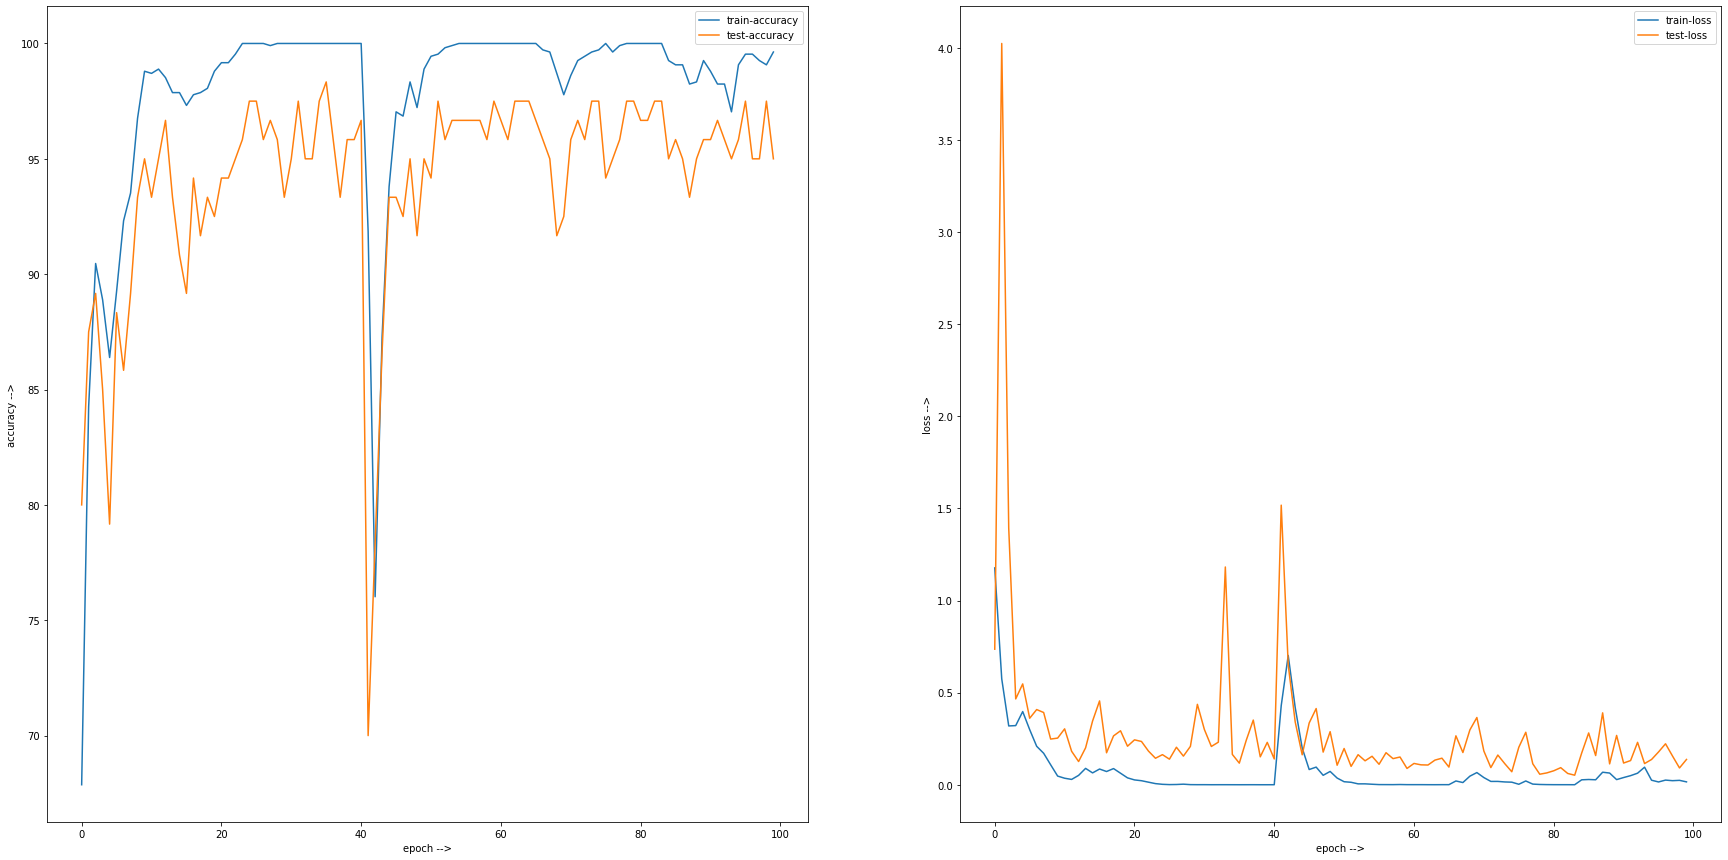

In [8]:
model, train_losses, train_accuracies, test_losses, test_accuracies = learn_model(
    train_data=train_data, test_data=test_data, model=model, 
    learning_rate=9e-3, beta1=0.9, beta2=0.999, epsilon=1e-08, 
    num_epochs=100, batch_size=64)
test_loss, test_accuracy = evaluate_model(model=model, test_data=test_data, 
    batch_size=64, loss_func=nn.NLLLoss(reduction='mean'))
print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

visualize_training(train_accuracies=train_accuracies, train_losses=train_losses,
    test_accuracies=test_accuracies, test_losses=test_losses)